# Bag-of-Words Classication with Histograms of oriented gradients

## 1. Feature Description with Histograms of Oriented Gradients (HOG)

In [43]:
from pathlib import Path
import numpy as np
from PIL import Image
from scipy.ndimage import sobel
import scipy
import json
import csv
import glob
import os
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt


In [2]:
def load_image_gray(path: str) -> np.ndarray:

    img = Image.open(path).convert("L")
    I = np.asarray(img, dtype=np.float32) / 255.0
    return I


### 1.1 Creating a HOG computing function

### Step 1 :

In [3]:
def make_grid_indices(h: int, w: int, n_points_x: int, n_points_y: int, patch_half: int = 8):

    x_min, x_max = patch_half, w - patch_half - 1
    y_min, y_max = patch_half, h - patch_half - 1
    if x_min > x_max or y_min > y_max:
        raise ValueError("Image trop petite pour des patches 16x16 avec ces marges.")


    xs_line = np.linspace(x_min, x_max, n_points_x, dtype=np.int32)
    ys_line = np.linspace(y_min, y_max, n_points_y, dtype=np.int32)


    X, Y = np.meshgrid(xs_line, ys_line)
    xs = X.reshape(-1)
    ys = Y.reshape(-1)

    assert xs.shape == ys.shape == (n_points_x * n_points_y,)
    return xs, ys



### Step 2 :

In [19]:
def hog_descriptors(I, xs, ys, cell_size=4, cells_per_patch=4, nbins=8):


    assert I.ndim == 2, "Image doit être en niveaux de gris"


    patch_half = (cell_size * cells_per_patch) // 2


    Gx = sobel(I, axis=1, mode="reflect")
    Gy = sobel(I, axis=0, mode="reflect")
    magnitude = np.hypot(Gx, Gy)
    angle = np.arctan2(Gy, Gx)


    bin_edges = np.linspace(-np.pi, np.pi, nbins + 1)


    n_points = len(xs)
    descriptors = np.zeros((n_points, cells_per_patch * cells_per_patch * nbins), dtype=np.float32)


    for i, (x, y) in enumerate(zip(xs, ys)):

        patch_ang = angle[y - patch_half:y + patch_half, x - patch_half:x + patch_half]
        patch_mag = magnitude[y - patch_half:y + patch_half, x - patch_half:x + patch_half]


        desc = []
        for cy in range(cells_per_patch):
            for cx in range(cells_per_patch):
                cell_ang = patch_ang[cy*cell_size:(cy+1)*cell_size, cx*cell_size:(cx+1)*cell_size]
                cell_mag = patch_mag[cy*cell_size:(cy+1)*cell_size, cx*cell_size:(cx+1)*cell_size]
                hist, _ = np.histogram(cell_ang.ravel(), bins=bin_edges, weights=cell_mag.ravel())
                desc.extend(hist)
        descriptors[i] = np.array(desc)

    return descriptors



In [20]:
I = load_image_gray("STL10/stl10_raw/train/airplane/airplane_train_000.png")
h, w = I.shape
xs, ys = make_grid_indices(h, w, n_points_x=12, n_points_y=12, patch_half=8)
D = hog_descriptors(I, xs, ys)
print(D.shape, D.dtype)

(144, 128) float32


### 1.2 Computing the dataset

In [5]:
def compute_hog_dataset_npz(in_dir, out_file,
                            n_points_x=12, n_points_y=12,
                            cell_size=4, cells_per_patch=4, nbins=8, patch_half=8):
    in_dir = Path(in_dir)

    img_paths = []
    for ext in ("*.png", "*.jpg", "*.jpeg"):
        img_paths.extend(glob.glob(str(in_dir / ext)))
    img_paths = sorted(img_paths)
    print("Nombre d'images trouvées :", len(img_paths))
    if len(img_paths) == 0:
        raise FileNotFoundError(f"Aucune image dans {in_dir}")


    all_descs = []
    for i, img_path in enumerate(img_paths, 1):
        I = load_image_gray(img_path)
        h, w = I.shape
        xs, ys = make_grid_indices(h, w, n_points_x, n_points_y, patch_half)
        D = hog_descriptors(I, xs, ys, cell_size, cells_per_patch, nbins)
        all_descs.append(D)
        if i % 50 == 0 or i == len(img_paths):
            print(f"{i}/{len(img_paths)} images traitées")


    ALL = np.vstack(all_descs).astype(np.float32)
    np.savez_compressed(out_file, all_descs=ALL)
    print("Sauvegardé :", out_file, "| shape =", ALL.shape)

In [6]:

compute_hog_dataset_npz(
    in_dir="STL10/stl10_raw/train/airplane",
    out_file="HOG_computation/train/airplane_train.npz"
)


Nombre d'images trouvées : 500
50/500 images traitées
100/500 images traitées
150/500 images traitées
200/500 images traitées
250/500 images traitées
300/500 images traitées
350/500 images traitées
400/500 images traitées
450/500 images traitées
500/500 images traitées
Sauvegardé : HOG_computation/train/airplane_train.npz | shape = (72000, 128)


In [7]:
compute_hog_dataset_npz(
    in_dir="STL10/stl10_raw/train/bird",
    out_file="HOG_computation/train/bird_train.npz"
)

Nombre d'images trouvées : 500
50/500 images traitées
100/500 images traitées
150/500 images traitées
200/500 images traitées
250/500 images traitées
300/500 images traitées
350/500 images traitées
400/500 images traitées
450/500 images traitées
500/500 images traitées
Sauvegardé : HOG_computation/train/bird_train.npz | shape = (72000, 128)


In [8]:
compute_hog_dataset_npz(
    in_dir="STL10/stl10_raw/train/car",
    out_file="HOG_computation/train/car_train.npz"
)

Nombre d'images trouvées : 500
50/500 images traitées
100/500 images traitées
150/500 images traitées
200/500 images traitées
250/500 images traitées
300/500 images traitées
350/500 images traitées
400/500 images traitées
450/500 images traitées
500/500 images traitées
Sauvegardé : HOG_computation/train/car_train.npz | shape = (72000, 128)


In [9]:
compute_hog_dataset_npz(
    in_dir="STL10/stl10_raw/train/cat",
    out_file="HOG_computation/train/cat_train.npz"
)

Nombre d'images trouvées : 500
50/500 images traitées
100/500 images traitées
150/500 images traitées
200/500 images traitées
250/500 images traitées
300/500 images traitées
350/500 images traitées
400/500 images traitées
450/500 images traitées
500/500 images traitées
Sauvegardé : HOG_computation/train/cat_train.npz | shape = (72000, 128)


In [10]:
compute_hog_dataset_npz(
    in_dir="STL10/stl10_raw/train/deer",
    out_file="HOG_computation/train/deer_train.npz"
)

Nombre d'images trouvées : 500
50/500 images traitées
100/500 images traitées
150/500 images traitées
200/500 images traitées
250/500 images traitées
300/500 images traitées
350/500 images traitées
400/500 images traitées
450/500 images traitées
500/500 images traitées
Sauvegardé : HOG_computation/train/deer_train.npz | shape = (72000, 128)


In [11]:
compute_hog_dataset_npz(
    in_dir="STL10/stl10_raw/train/dog",
    out_file="HOG_computation/train/dog_train.npz"
)

Nombre d'images trouvées : 500
50/500 images traitées
100/500 images traitées
150/500 images traitées
200/500 images traitées
250/500 images traitées
300/500 images traitées
350/500 images traitées
400/500 images traitées
450/500 images traitées
500/500 images traitées
Sauvegardé : HOG_computation/train/dog_train.npz | shape = (72000, 128)


In [12]:
compute_hog_dataset_npz(
    in_dir="STL10/stl10_raw/train/horse",
    out_file="HOG_computation/train/horse_train.npz"
)

Nombre d'images trouvées : 500
50/500 images traitées
100/500 images traitées
150/500 images traitées
200/500 images traitées
250/500 images traitées
300/500 images traitées
350/500 images traitées
400/500 images traitées
450/500 images traitées
500/500 images traitées
Sauvegardé : HOG_computation/train/horse_train.npz | shape = (72000, 128)


In [13]:
compute_hog_dataset_npz(
    in_dir="STL10/stl10_raw/train/monkey",
    out_file="HOG_computation/train/monkey_train.npz"
)

Nombre d'images trouvées : 500
50/500 images traitées
100/500 images traitées
150/500 images traitées
200/500 images traitées
250/500 images traitées
300/500 images traitées
350/500 images traitées
400/500 images traitées
450/500 images traitées
500/500 images traitées
Sauvegardé : HOG_computation/train/monkey_train.npz | shape = (72000, 128)


In [14]:
compute_hog_dataset_npz(
    in_dir="STL10/stl10_raw/train/ship",
    out_file="HOG_computation/train/ship_train.npz"
)

Nombre d'images trouvées : 500
50/500 images traitées
100/500 images traitées
150/500 images traitées
200/500 images traitées
250/500 images traitées
300/500 images traitées
350/500 images traitées
400/500 images traitées
450/500 images traitées
500/500 images traitées
Sauvegardé : HOG_computation/train/ship_train.npz | shape = (72000, 128)


In [15]:
compute_hog_dataset_npz(
    in_dir="STL10/stl10_raw/train/truck",
    out_file="HOG_computation/train/truck_train.npz"
)

Nombre d'images trouvées : 500
50/500 images traitées
100/500 images traitées
150/500 images traitées
200/500 images traitées
250/500 images traitées
300/500 images traitées
350/500 images traitées
400/500 images traitées
450/500 images traitées
500/500 images traitées
Sauvegardé : HOG_computation/train/truck_train.npz | shape = (72000, 128)


In [16]:
# Charger les descripteurs
data = np.load("HOG_computation/train/airplane_train.npz")
X = data["all_descs"]



## 2. Visual Vocabulary Construction with K-means Clustering

### 2.1 K-means clustering

### Step 1 :

In [17]:

def init_random_centroids(X, K):
    idx = np.random.permutation(X.shape[0])[:K]
    return X[idx].astype(np.float32)


### Step 2 :

In [21]:

def assign_to_centroids(X, centroids):
    D = scipy.spatial.distance.cdist(X, centroids, metric="euclidean")
    return np.argmin(D, axis=1)


### Step 3 :

In [22]:

def update_centroids(X, labels, K):
    C = np.zeros((K, X.shape[1]), dtype=np.float32)
    for k in range(K):
        pts = X[labels == k]
        if pts.size:
            C[k] = pts.mean(axis=0)
        else:
            C[k] = X[np.random.randint(0, X.shape[0])]
    return C

### 2.2 Computing

In [23]:

def kmeans_clustering(X, K, max_iter=100, tol=1e-4):
    C = init_random_centroids(X, K)
    for _ in range(max_iter):
        labels = assign_to_centroids(X, C)
        C_new = update_centroids(X, labels, K)
        if np.max(np.abs(C_new - C)) < tol:
            return C_new
        C = C_new
    return C

In [25]:
def build_codebook_from_dirs(train_dirs, K=100, max_iter=10, max_points_per_class=200_000):
    X_all = []
    for d in train_dirs:
        data = np.load(d)["all_descs"]
        if data.shape[0] > max_points_per_class:
            idx = np.random.choice(data.shape[0], max_points_per_class, replace=False)
            data = data[idx]
        X_all.append(data.astype(np.float32))
    X_all = np.vstack(X_all)
    C = kmeans_clustering(X_all, K=K, max_iter=max_iter)
    return C

In [26]:
train_npz_dir = Path("HOG_computation/train")
npz_files_all = sorted(train_npz_dir.glob("*_train.npz"))
print(f"{len(npz_files_all)} fichiers trouvés :", [p.name for p in npz_files_all])

10 fichiers trouvés : ['airplane_train.npz', 'bird_train.npz', 'car_train.npz', 'cat_train.npz', 'deer_train.npz', 'dog_train.npz', 'horse_train.npz', 'monkey_train.npz', 'ship_train.npz', 'truck_train.npz']


In [27]:
# Choisis ton ensemble (tout ou 2 classes)
train_dirs = npz_files_all      # pour 10 classes
# train_dirs = npz_files_2      # pour 2 classes

K = 100
max_iter = 10
max_points_per_class = 200_000   # ajuste si tu manques de RAM ou si c'est trop long

C = build_codebook_from_dirs(
    train_dirs=train_dirs,
    K=K,
    max_iter=max_iter,
    max_points_per_class=max_points_per_class
)

print("Centroids shape:", C.shape)  # attendu (K, 128) si HOG 4x4x8
assert C.shape[0] == K and np.isfinite(C).all()

Centroids shape: (100, 128)


In [28]:
out_dir = Path("HOG_computation") / "codebooks"
out_dir.mkdir(parents=True, exist_ok=True)

classes_used = [p.stem.replace("_train","") for p in train_dirs]
out_path = out_dir / f"k{K}_{'ALL' if len(classes_used)>2 else '-'.join(classes_used)}.npz"

np.savez_compressed(out_path, centroids=C, K=K, classes=np.array(classes_used))
print("Codebook sauvegardé ->", out_path)

Codebook sauvegardé -> HOG_computation/codebooks/k100_ALL.npz


In [29]:
tmp = np.load(out_path)
C_loaded = tmp["centroids"]
print("Rechargé:", C_loaded.shape)

# Sanity check dimension des descripteurs
D = C_loaded.shape[1]
print("Dim des descripteurs (doit être 128 pour HOG 4x4x8):", D)

Rechargé: (100, 128)
Dim des descripteurs (doit être 128 pour HOG 4x4x8): 128


### BOW Histograms

In [38]:
def bow_hist_for_image(I, centroids,
                       n_points_x=12, n_points_y=12, patch_half=8,
                       cell_size=4, cells_per_patch=4, nbins=8,
                       norm="l2"):
    """
    Calcule le HOG dense de l'image I, assigne chaque descripteur au centroïde
    le plus proche, puis renvoie l'histogramme BoW (K bins).
    """
    # 1) Grille régulière de points
    h, w = I.shape
    xs, ys = make_grid_indices(h, w, n_points_x, n_points_y, patch_half)

    # 2) Descripteurs HOG  (shape: [n_points, 128])
    D = hog_descriptors(I, xs, ys, cell_size, cells_per_patch, nbins)

    # 3) Assignation au centroïde le plus proche
    # distances: [n_points, K] ; argmin -> index du mot visuel
    K = centroids.shape[0]
    lbls = np.argmin(cdist(D, centroids, metric="euclidean"), axis=1)

    # 4) Histogramme des mots visuels
    hist = np.bincount(lbls, minlength=K).astype(np.float32)

    # 5) Normalisation (recommandé pour 1-NN)
    if norm == "l2":
        denom = np.linalg.norm(hist) + 1e-12
        hist = hist / denom
    elif norm == "l1":
        denom = np.sum(np.abs(hist)) + 1e-12
        hist = hist / denom

    return hist  # shape: (K,)

In [39]:
def build_bow_for_dir(img_dir, centroids, label_id,
                      n_points_x=12, n_points_y=12, patch_half=8,
                      cell_size=4, cells_per_patch=4, nbins=8,
                      norm="l2"):
    """
    Parcourt toutes les images d'un dossier et renvoie:
      - H: matrice BoW [N_images, K]
      - y: labels [N_images] (tous égaux à label_id)
    """
    exts = ("*.png", "*.jpg", "*.jpeg")
    paths = []
    for e in exts:
        paths.extend(glob.glob(os.path.join(img_dir, e)))
    paths = sorted(paths)

    H, y = [], []
    for p in paths:
        I = load_image_gray(p)
        h = bow_hist_for_image(I, centroids,
                               n_points_x, n_points_y, patch_half,
                               cell_size, cells_per_patch, nbins, norm)
        H.append(h)
        y.append(label_id)

    if len(H) == 0:
        # important pour éviter vstack vide
        return np.zeros((0, centroids.shape[0]), dtype=np.float32), np.zeros((0,), dtype=np.int32)

    return np.vstack(H).astype(np.float32), np.array(y, dtype=np.int32)



In [40]:
# --- 3) BoW pour un ensemble multi-classes (train OU test) ---
def build_bow_set(root_dir, class_names, centroids,
                  n_points_x=12, n_points_y=12, patch_half=8,
                  cell_size=4, cells_per_patch=4, nbins=8,
                  norm="l2"):
    """
    root_dir: chemin racine, ex: 'STL10/stl10_raw/train' ou '.../test'
    class_names: liste classe -> str (ordre = id)
    """
    H_list, y_list = [], []
    for cid, cls in enumerate(class_names):
        img_dir = os.path.join(root_dir, cls)
        H_cls, y_cls = build_bow_for_dir(img_dir, centroids, cid,
                                         n_points_x, n_points_y, patch_half,
                                         cell_size, cells_per_patch, nbins, norm)
        H_list.append(H_cls); y_list.append(y_cls)

    H = np.vstack(H_list) if len(H_list) else np.zeros((0, centroids.shape[0]), dtype=np.float32)
    y = np.concatenate(y_list) if len(y_list) else np.zeros((0,), dtype=np.int32)
    return H, y

In [41]:
# 1) Charger le codebook
cb = np.load("HOG_computation/codebooks/k100_ALL.npz")
centroids = cb["centroids"]  # shape (K, 128)
K = centroids.shape[0]

# 2) Choisir les classes (2 classes pour commencer, puis les 10)
classes = ["airplane", "car"]   # ou: ["airplane","bird","car","cat","deer","dog","horse","monkey","ship","truck"]

# 3) Construire BoW pour train et test
H_train, y_train = build_bow_set("STL10/stl10_raw/train", classes, centroids, norm="l2")
H_test,  y_test  = build_bow_set("STL10/stl10_raw/test",  classes, centroids, norm="l2")

print("H_train:", H_train.shape, " y_train:", y_train.shape)
print("H_test :", H_test.shape,  " y_test :", y_test.shape)

# 4) Sauvegarder pour réutiliser
np.savez_compressed(f"HOG_computation/bow_k{K}_{'-'.join(classes)}.npz",
                    H_train=H_train, y_train=y_train,
                    H_test=H_test,   y_test=y_test,
                    classes=np.array(classes))

H_train: (1000, 100)  y_train: (1000,)
H_test : (1600, 100)  y_test : (1600,)


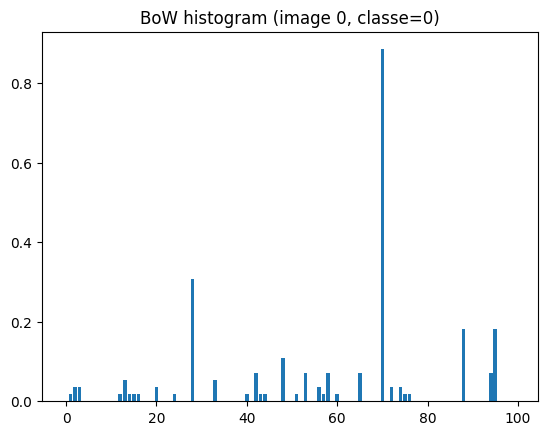

In [44]:
plt.bar(range(H_train.shape[1]), H_train[0])
plt.title(f"BoW histogram (image 0, classe={y_train[0]})")
plt.show()

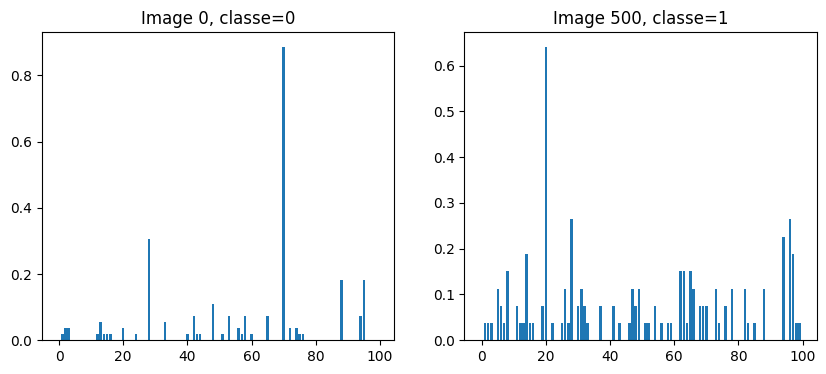

In [45]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.bar(range(H_train.shape[1]), H_train[0])
plt.title(f"Image 0, classe={y_train[0]}")

plt.subplot(1,2,2)
plt.bar(range(H_train.shape[1]), H_train[500])  # une autre image
plt.title(f"Image 500, classe={y_train[500]}")

plt.show()

In [46]:
def nn_classifier_l2(H_train: np.ndarray, y_train: np.ndarray,
                     H_test: np.ndarray) -> np.ndarray:
    """
    Prédit les labels de H_test en 1-Nearest Neighbor (distance euclidienne, L2)
    - H_train : matrice BoW d'entraînement, shape (N_train, K)
    - y_train : labels d'entraînement, shape (N_train,)
    - H_test  : matrice BoW de test, shape (N_test, K)
    Retour : y_pred, shape (N_test,)
    """
    # 1) Distances entre chaque test et tous les train  -> (N_test, N_train)
    D = cdist(H_test, H_train, metric="euclidean")
    # 2) Indice du plus proche voisin pour chaque test -> (N_test,)
    nn_idx = np.argmin(D, axis=1)
    # 3) Labels prédits = labels des voisins les plus proches
    y_pred = y_train[nn_idx]
    return y_pred

In [47]:
def accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float((y_true == y_pred).mean())

def check_shapes(H_train, y_train, H_test, y_test):
    assert H_train.ndim == 2 and H_test.ndim == 2, "H_train/H_test doivent être 2D"
    assert y_train.ndim == 1 and y_test.ndim == 1, "y_train/y_test doivent être 1D"
    assert H_train.shape[1] == H_test.shape[1], "Même K (nb de bins) pour train et test"
    assert H_train.shape[0] == y_train.shape[0], "Nb images train cohérent"
    assert H_test.shape[0]  == y_test.shape[0],  "Nb images test cohérent"

In [48]:
# Suppose que tu as déjà :
# H_train, y_train, H_test, y_test  (depuis l’étape 1.5)
check_shapes(H_train, y_train, H_test, y_test)

# 1) Prédire avec 1-NN (L2)
y_pred = nn_classifier_l2(H_train, y_train, H_test)

# 2) Mesurer l’accuracy
acc = accuracy(y_test, y_pred)
print(f"Accuracy 1-NN (L2) : {acc:.3f}")

Accuracy 1-NN (L2) : 0.787


In [50]:

# 1) Charger les BoW déjà prêts (airplane vs car)
d = np.load("HOG_computation/bow_k100_airplane-car.npz")
H_train, y_train, H_test, y_test = d["H_train"], d["y_train"], d["H_test"], d["y_test"]

# 2) 1-NN L2
y_pred = y_train[np.argmin(cdist(H_test, H_train, metric="euclidean"), axis=1)]
acc = (y_pred == y_test).mean()
print(f"[2 classes | K=100 | L2] accuracy = {acc:.3f}")

[2 classes | K=100 | L2] accuracy = 0.787


In [52]:
cb = np.load("HOG_computation/codebooks/k100_ALL.npz")
centroids = cb["centroids"]

bow_10_path = Path("HOG_computation/bow_k100_ALL.npz")
if not bow_10_path.exists():
    classes_10 = ["airplane","bird","car","cat","deer","dog","horse","monkey","ship","truck"]
    # build_bow_set est déjà dans ton notebook – on le réutilise
    H_train, y_train = build_bow_set("STL10/stl10_raw/train", classes_10, centroids, norm="l2")
    H_test,  y_test  = build_bow_set("STL10/stl10_raw/test",  classes_10, centroids, norm="l2")
    np.savez_compressed(bow_10_path, H_train=H_train, y_train=y_train, H_test=H_test, y_test=y_test, classes=np.array(classes_10))
    print("BoW 10 classes calculé puis sauvegardé.")
else:
    print("BoW 10 classes déjà présent, on le charge.")
    d10 = np.load(bow_10_path)
    H_train, y_train, H_test, y_test = d10["H_train"], d10["y_train"], d10["H_test"], d10["y_test"]

# Évaluer L2 (un seul run, pas de réapprentissage)
y_pred = y_train[np.argmin(cdist(H_test, H_train, metric="euclidean"), axis=1)]
acc = (y_pred == y_test).mean()
print(f"[10 classes | K=100 | L2] accuracy = {acc:.3f}  | baseline ~ {1/10:.2f}")

KeyboardInterrupt: 